In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [115]:
df = pd.read_csv('DATA.csv', index_col=0)

In [116]:
df.head()

,quote_date,expiration_C,strike,option_type_C,bid_1545_C,ask_1545_C,expiration_P,option_type_P,bid_1545_P,ask_1545_P,date,rate,implied_S_x,moneyness,implied_S_y
0,2018-01-12,2018-02-09,5400.0,C,1347.0,1368.3,2018-02-09,P,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067
1,2018-01-12,2018-02-09,5500.0,C,1248.0,1269.0,2018-02-09,P,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067
2,2018-01-12,2018-02-09,5600.0,C,1151.6,1165.9,2018-02-09,P,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655,6751.233067
3,2018-01-12,2018-02-09,5700.0,C,1052.4,1066.7,2018-02-09,P,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256,6751.233067
4,2018-01-12,2018-02-09,5800.0,C,953.1,967.4,2018-02-09,P,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067


In [117]:
df['expiration_C']=pd.to_datetime(df['expiration_C'])

In [118]:
nasdaq = pd.read_csv('NASDAQ.csv')

In [119]:
nasdaq.head()

,Date,Close/Last,Open,High,Low
0,01/03/2024,16368.49,16413.26,16471.08,16352.14
1,01/02/2024,16543.94,16667.30,16686.60,16453.15
2,12/29/2023,16825.93,16902.44,16919.51,16757.89
3,12/28/2023,16898.47,16963.52,16969.17,16891.32
4,12/27/2023,16906.80,16896.14,16922.01,16859.55


In [120]:
nasdaq['Date']=pd.to_datetime(nasdaq['Date'])

In [121]:
newdf = pd.merge(df, nasdaq, how='left', left_on='expiration_C', right_on='Date')

In [122]:
newdf['expiration_C'].nunique()

56

In [123]:
# nasdaq_vol = pd.read_csv('NASDAQ_vol.csv')  

In [124]:
# nasdaq_vol['Date_vol']=pd.to_datetime(nasdaq_vol['Date'])
# nasdaq_vol['vol'] = nasdaq_vol['Close/Last']

In [125]:
# newdf = pd.merge(newdf, nasdaq_vol, how='left', left_on='expiration_C', right_on='Date_vol')

In [126]:
newdf['strike_adj'] = newdf['strike'] / newdf['implied_S_y']

In [127]:
newdf['strike_adj'].describe()

count    10898.000000
mean         0.990330
std          0.155167
min          0.504835
25%          0.879193
50%          0.989446
75%          1.096986
max          1.535656
Name: strike_adj, dtype: float64

In [132]:
newdf['pnl_long_Call'] =  np.max(newdf['Close/Last']-newdf['strike'],0)-(newdf['bid_1545_C']+newdf['ask_1545_C'])/2
newdf['pnl_long_Put'] =  np.max(newdf['strike']-newdf['Close/Last'],0)-(newdf['bid_1545_C']+newdf['ask_1545_C'])/2
newdf['pnl_short_Call'] = (newdf['bid_1545_C']+newdf['ask_1545_C'])/2 - np.max(newdf['strike']-newdf['Close/Last'],0)
newdf['pnl_short_Put'] =  (newdf['bid_1545_C']+newdf['ask_1545_C'])/2 - np.max(newdf['Close/Last']-newdf['strike'],0)

In [134]:
newdf.expiration_C

0       2018-02-09
1       2018-02-09
2       2018-02-09
3       2018-02-09
4       2018-02-09
           ...    
10893   2022-12-09
10894   2022-12-09
10895   2022-12-09
10896   2022-12-09
10897   2022-12-09
Name: expiration_C, Length: 10898, dtype: datetime64[ns]

In [135]:
newdf.strike.value_counts()

8000.0    35
9000.0    34
8500.0    34
8100.0    33
8200.0    33
          ..
8770.0     1
8760.0     1
8740.0     1
8730.0     1
9370.0     1
Name: strike, Length: 861, dtype: int64

In [136]:
print(len(newdf[newdf['expiration_C']=='2018-02-09']))
print(len(newdf[newdf['expiration_C']=='2022-12-09']))

118
241


In [137]:
def adj_strike_min(group):
    return group['strike_adj'].min()

def adj_strike_max(group):
    return group['strike_adj'].max()

subset_min = newdf.groupby("quote_date").apply(adj_strike_min).max()
subset_max = newdf.groupby("quote_date").apply(adj_strike_max).min()
print(f'The overlapped interval is ({subset_min:.3}, {subset_max:.3})')

The overlapped interval is (0.8, 1.09)


In [138]:
newdf = newdf[(newdf['strike_adj']>=subset_min) & (newdf['strike_adj']<=subset_max)]    

In [139]:
newdf.groupby("quote_date").size().min()

41

In [140]:
# uniformly draw 41 samples of strike_adj from each date
sample_size = 41
newdf_sampled = newdf.groupby('quote_date').apply(lambda x: x.sample(n=sample_size, random_state=42)).reset_index(drop=True)

In [141]:
# rank the strike_adj within each date
newdf_sampled['strike_adj_rank'] = newdf_sampled.groupby('quote_date')['strike_adj'].rank()

In [112]:
# # check for 2018-01-12
# newdf_sampled[newdf_sampled['quote_date']=='2018-01-12'].sort_values('strike_adj')

In [142]:
newdf_sampled

,quote_date,expiration_C,strike,option_type_C,bid_1545_C,ask_1545_C,expiration_P,option_type_P,bid_1545_P,ask_1545_P,date,rate,implied_S_x,moneyness,implied_S_y,Date,Close/Last,Open,High,Low,strike_adj,pnl_long_Call,pnl_long_Put,pnl_short_Call,pnl_short_Put,strike_adj_rank
0,2018-01-12,2018-02-09,6830.0,C,59.1,64.7,2018-02-09,P,129.2,136.5,2018-01-12,0.0131,6751.646347,-78.353653,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,1.011667,5875.94,7105.28,-7105.28,-5875.94,33.0
1,2018-01-12,2018-02-09,6100.0,C,658.0,672.1,2018-02-09,P,6.4,9.0,2018-01-12,0.0131,6750.737660,650.737660,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,0.903539,5272.79,6502.13,-6502.13,-5272.79,5.0
2,2018-01-12,2018-02-09,5800.0,C,953.1,967.4,2018-02-09,P,2.4,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,0.859102,4977.59,6206.93,-6206.93,-4977.59,2.0
3,2018-01-12,2018-02-09,6880.0,C,41.6,44.6,2018-02-09,P,159.7,168.0,2018-01-12,0.0131,6751.792148,-128.207852,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,1.019073,5894.74,7124.08,-7124.08,-5894.74,37.0
4,2018-01-12,2018-02-09,6720.0,C,116.1,122.9,2018-02-09,P,77.7,84.1,2018-01-12,0.0131,6751.315586,31.315586,6751.233067,2018-02-09,6412.68,6395.16,6453.43,6164.43,0.995374,5818.34,7047.68,-7047.68,-5818.34,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,2022-11-11,2022-12-09,11975.0,C,282.8,288.6,2022-12-09,P,413.6,424.9,2022-11-11,0.0371,11805.152658,-169.847342,11805.333099,2022-12-09,11563.33,11594.38,11707.09,11550.31,1.014372,5652.14,6881.48,-6881.48,-5652.14,30.0
2292,2022-11-11,2022-12-09,9450.0,C,2379.5,2403.6,2022-12-09,P,7.1,9.5,2022-11-11,0.0371,11804.606168,2354.606168,11805.333099,2022-12-09,11563.33,11594.38,11707.09,11550.31,0.800486,3546.29,4775.63,-4775.63,-3546.29,1.0
2293,2022-11-11,2022-12-09,11400.0,C,621.0,631.6,2022-12-09,P,183.8,189.2,2022-11-11,0.0371,11805.245536,405.245536,11805.333099,2022-12-09,11563.33,11594.38,11707.09,11550.31,0.965665,5311.54,6540.88,-6540.88,-5311.54,24.0
2294,2022-11-11,2022-12-09,11000.0,C,926.7,946.8,2022-12-09,P,97.0,100.3,2022-11-11,0.0371,11804.757974,804.757974,11805.333099,2022-12-09,11563.33,11594.38,11707.09,11550.31,0.931782,5001.09,6230.43,-6230.43,-5001.09,18.0


In [161]:
pnl = pd.DataFrame(index=newdf_sampled['quote_date'].unique())

for i in range(1, 42):
    pnl[f'long_Call_{i}'] = newdf_sampled[newdf_sampled['strike_adj_rank']==i][['quote_date','pnl_long_Call']].set_index('quote_date')
    pnl[f'long_Put_{i}'] = newdf_sampled[newdf_sampled['strike_adj_rank']==i][['quote_date','pnl_long_Put']].set_index('quote_date')
    pnl[f'short_Call_{i}'] = newdf_sampled[newdf_sampled['strike_adj_rank']==i][['quote_date','pnl_short_Call']].set_index('quote_date')
    pnl[f'short_Put_{i}'] = newdf_sampled[newdf_sampled['strike_adj_rank']==i][['quote_date','pnl_short_Put']].set_index('quote_date')

/var/folders/jb/bxbmc2q970l2l1j4xlhcq9980000gn/T/ipykernel_6246/1907047230.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pnl[f'long_Call_{i}'] = newdf_sampled[newdf_sampled['strike_adj_rank']==i][['quote_date','pnl_long_Call']].set_index('quote_date')
/var/folders/jb/bxbmc2q970l2l1j4xlhcq9980000gn/T/ipykernel_6246/1907047230.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pnl[f'long_Put_{i}'] = newdf_sampled[newdf_sampled['strike_adj_rank']==i][['quote_date','pnl_long_Put']].set_index('quote_date')
/var/folders/jb/bxbm

In [162]:
pnl

,long_Call_1,long_Put_1,short_Call_1,short_Put_1,long_Call_2,long_Put_2,short_Call_2,short_Put_2,long_Call_3,long_Put_3,short_Call_3,short_Put_3,long_Call_4,long_Put_4,short_Call_4,short_Put_4,long_Call_5,long_Put_5,short_Call_5,short_Put_5,long_Call_6,long_Put_6,short_Call_6,short_Put_6,long_Call_7,long_Put_7,short_Call_7,short_Put_7,long_Call_8,long_Put_8,short_Call_8,short_Put_8,long_Call_9,long_Put_9,short_Call_9,short_Put_9,long_Call_10,long_Put_10,short_Call_10,short_Put_10,long_Call_11,long_Put_11,short_Call_11,short_Put_11,long_Call_12,long_Put_12,short_Call_12,short_Put_12,long_Call_13,long_Put_13,short_Call_13,short_Put_13,long_Call_14,long_Put_14,short_Call_14,short_Put_14,long_Call_15,long_Put_15,short_Call_15,short_Put_15,long_Call_16,long_Put_16,short_Call_16,short_Put_16,long_Call_17,long_Put_17,short_Call_17,short_Put_17,long_Call_18,long_Put_18,short_Call_18,short_Put_18,long_Call_19,long_Put_19,short_Call_19,short_Put_19,long_Call_20,long_Put_20,short_Call_20,short_Put_20,long_Call_21,long_Put_21,short_Call_21,short_Put_21,long_Call_22,long_Put_22,short_Call_22,short_Put_22,long_Call_23,long_Put_23,short_Call_23,short_Put_23,long_Call_24,long_Put_24,short_Call_24,short_Put_24,long_Call_25,long_Put_25,short_Call_25,short_Put_25,long_Call_26,long_Put_26,short_Call_26,short_Put_26,long_Call_27,long_Put_27,short_Call_27,short_Put_27,long_Call_28,long_Put_28,short_Call_28,short_Put_28,long_Call_29,long_Put_29,short_Call_29,short_Put_29,long_Call_30,long_Put_30,short_Call_30,short_Put_30,long_Call_31,long_Put_31,short_Call_31,short_Put_31,long_Call_32,long_Put_32,short_Call_32,short_Put_32,long_Call_33,long_Put_33,short_Call_33,short_Put_33,long_Call_34,long_Put_34,short_Call_34,short_Put_34,long_Call_35,long_Put_35,short_Call_35,short_Put_35,long_Call_36,long_Put_36,short_Call_36,short_Put_36,long_Call_37,long_Put_37,short_Call_37,short_Put_37,long_Call_38,long_Put_38,short_Call_38,short_Put_38,long_Call_39,long_Put_39,short_Call_39,short_Put_39,long_Call_40,long_Put_40,short_Call_40,short_Put_40,long_Call_41,long_Put_41,short_Call_41,short_Put_41
2018-01-12,4580.19,5809.53,-5809.53,-4580.19,4977.59,6206.93,-6206.93,-4977.59,5076.19,6305.53,-6305.53,-5076.19,5248.59,6477.93,-6477.93,-5248.59,5272.79,6502.13,-6502.13,-5272.79,5297.19,6526.53,-6526.53,-5297.19,5321.69,6551.03,-6551.03,-5321.69,5394.39,6623.73,-6623.73,-5394.39,5466.29,6695.63,-6695.63,-5466.29,5532.59,6761.93,-6761.93,-5532.59,5560.49,6789.83,-6789.83,-5560.49,5578.84,6808.18,-6808.18,-5578.84,5587.99,6817.33,-6817.33,-5587.99,5597.09,6826.43,-6826.43,-5597.09,5615.14,6844.48,-6844.48,-5615.14,5632.84,6862.18,-6862.18,-5632.84,5667.69,6897.03,-6897.03,-5667.69,5675.79,6905.13,-6905.13,-5675.79,5692.69,6922.03,-6922.03,-5692.69,5701.24,6930.58,-6930.58,-5701.24,5713.24,6942.58,-6942.58,-5713.24,5752.59,6981.93,-6981.93,-5752.59,5763.79,6993.13,-6993.13,-5763.79,5771.04,7000.38,-7000.38,-5771.04,5805.74,7035.08,-7035.08,-5805.74,5818.34,7047.68,-7047.68,-5818.34,5821.39,7050.73,-7050.73,-5821.39,5836.29,7065.63,-7065.63,-5836.29,5841.39,7070.73,-7070.73,-5841.39,5846.99,7076.33,-7076.33,-5846.99,5852.34,7081.68,-7081.68,-5852.34,5871.49,7100.83,-7100.83,-5871.49,5875.940,7105.280,-7105.280,-5875.940,5880.29,7109.63,-7109.63,-5880.29,5884.19,7113.53,-7113.53,-5884.19,5887.840,7117.180,-7117.180,-5887.840,5894.740,7124.080,-7124.080,-5894.740,5907.890,7137.230,-7137.230,-5907.890,5909.140,7138.480,-7138.480,-5909.140,5922.440,7151.780,-7151.780,-5922.440,5936.115,7165.455,-7165.455,-5936.115
2018-02-09,4716.74,5946.08,-5946.08,-4716.74,4956.54,6185.88,-6185.88,-4956.54,4980.14,6209.48,-6209.48,-4980.14,5073.79,6303.13,-6303.13,-5073.79,5096.99,6326.33,-6326.33,-5096.99,5120.04,6349.38,-6349.38,-5120.04,5143.09,6372.43,-6372.43,-5143.09,5211.49,6440.83,-6440.83,-5211.49,5234.04,6463.38,-6463.38,-5234.04,5278.74,6508.08,-6508.08,-5278.74,5366.44,6595.78,-6595.78,-5366.44,5451.34,6680.68,-6680.68,-5451.34,5492.49,6721.83,-6721.83,-5492.49,5532.74,6762.08,-

In [165]:
Sigma = pnl.cov()
mu = pnl.mean()

In [56]:
pip install cvxpy

     |████████████████████████████████| 1.1 MB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 252 kB 46.2 MB/s eta 0:00:01
     |████████████████████████████████| 108 kB 27.4 MB/s eta 0:00:01
     |████████████████████████████████| 987 kB 42.9 MB/s eta 0:00:01
     |████████████████████████████████| 105 kB 39.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
Sigma = pnl.cov()
mu = pnl.mean()

In [167]:
len(mu)

164

In [170]:
Sigma.shape

(164, 164)

In [174]:
import numpy as np
import cvxpy as cp

# Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
# mu as a random n-vector, would be substituded by the expected return
n = 164
mu = pnl.mean().to_numpy()
Sigma = pnl.cov()
lam = 1.
Sigma_1 = Sigma + lam * np.identity(n)

# constraints 
# h=0_n, A=1_n, b=1
# Gw >= h equiv to w_i>=0 for all i
# Aw = b equiv to sum(w_i)=1
h = np.zeros(n)
A = np.ones(n)
b = 1

# Define and solve the CVXPY problem.
w = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(w, Sigma_1) - mu.T @ w),
                 [w >= h,
                  A.T @ w == b])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution w is")
print(w.value)


The optimal value is -6781.810462763801
A solution w is
[ 2.06365831e-22  2.21060641e-22 -2.09732426e-22 -1.93987986e-22
  2.13842892e-22  2.19971575e-22 -2.10319808e-22 -2.05212572e-22
  2.16741414e-22  2.39211978e-22 -2.24454533e-22 -2.01983969e-22
  2.14366210e-22  2.24528067e-22 -2.11942622e-22 -2.06861694e-22
  2.25777959e-22  2.39970540e-22 -2.28458969e-22 -2.11225121e-22
  2.26560297e-22  2.32650724e-22 -2.20092870e-22 -2.14002443e-22
  2.17400023e-22  2.25557018e-22 -2.12886252e-22 -2.06768505e-22
  2.19907255e-22  2.32211271e-22 -2.18372851e-22 -2.06068834e-22
  2.26004345e-22  2.28061869e-22 -2.12076688e-22 -2.08990401e-22
  2.34341413e-22  2.03460232e-22 -1.91575400e-22 -2.22456580e-22
  2.17354791e-22  2.27795779e-22 -2.12421235e-22 -2.03024345e-22
  2.09691096e-22  2.05469385e-22 -1.94004002e-22 -1.94004002e-22
  2.02530030e-22  2.02530030e-22 -1.88366504e-22 -1.91600547e-22
  2.03897061e-22  1.99548222e-22 -1.82967617e-22 -1.87316456e-22
  2.08872881e-22  2.06674018e-22 

In [178]:
pnl.columns

Index(['long_Call_1', 'long_Put_1', 'short_Call_1', 'short_Put_1', 'long_Call_2', 'long_Put_2', 'short_Call_2', 'short_Put_2', 'long_Call_3', 'long_Put_3',
       ...
       'short_Call_39', 'short_Put_39', 'long_Call_40', 'long_Put_40', 'short_Call_40', 'short_Put_40', 'long_Call_41', 'long_Put_41', 'short_Call_41', 'short_Put_41'], dtype='object', length=164)

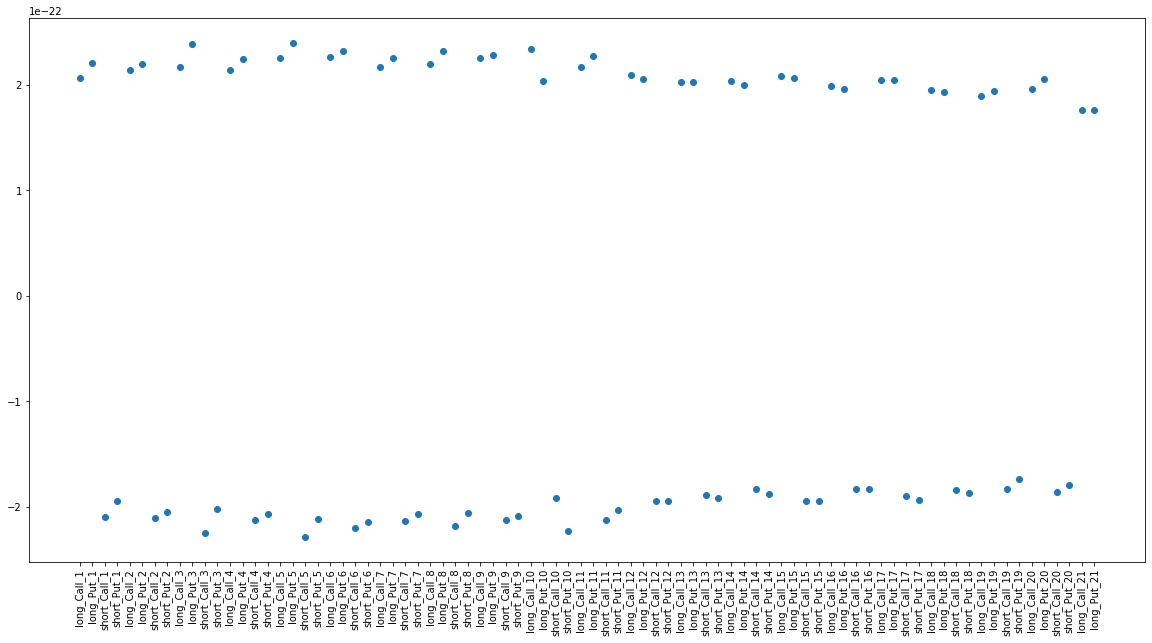

In [185]:
# graph weights vs strike, see if at 1 it is a peak/valley
plt.figure(figsize=(20,10))
plt.scatter(pnl.columns[:82], w.value[:82])
plt.xticks(rotation=90)
plt.show()

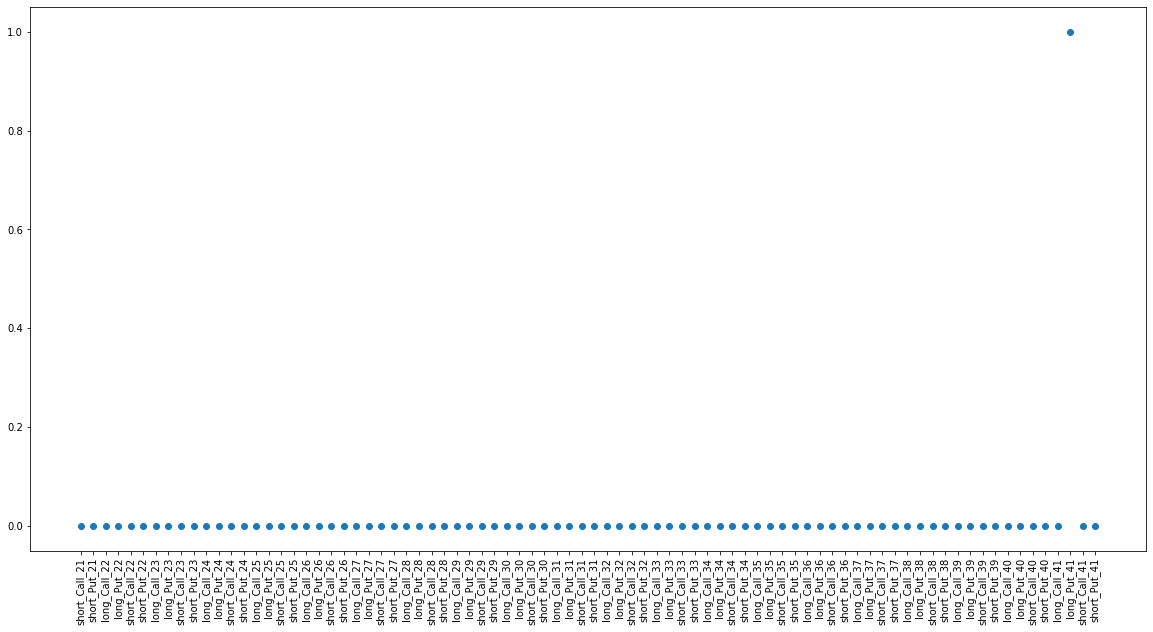

In [187]:
# graph weights vs strike, see if at 1 it is a peak/valley
plt.figure(figsize=(20,10))
plt.scatter(pnl.columns[82:], w.value[82:])
plt.xticks(rotation=90)
plt.show()